# Data Analysis Demo

This notebook is part of the documentation for the `gtfs_tripify` library, a Python module which allows you to extract realtime train arrival data for MTA trains in New York City from archival messages from the city's [GTFS-RT feeds](http://web.mta.info/developers/data/archives.html) (which are used to power the station arrival clocks, app-based arrival estimates, and so on). Although not required, it is helpful if you have already skimmed the `gtfs_tripify` [documentation](https://residentmario.github.io/gtfs-tripify/index.html), especially the [Quickstart](https://residentmario.github.io/gtfs-tripify/quickstart.html) and [Tutorial](https://residentmario.github.io/gtfs-tripify/tutorial.html) sections, as is provides good background for this demo.

The purpose of this demo is to demonstrate some interesting facts about mass transit in New York City which can be learned by analyzing parsed GTFS-RT stream data. We wil use the `gtfs_tripify` library and the [MTA GTFS-RT Archive](http://web.mta.info/developers/data/archives.html) to construct estimated train arrival times of every 7 train trip that occurred on June 1st, 2019. We will then perform an exploratory analysis of this data using `pandas` and Python.

**TODO**: make this notebook runnable via Binder by parcelling the data into a GitHub repo and downloading from there, and paste a link to it in the documentation and on the GitHub repo `README.md`.

## Pre-processing

Before we can analyze the we first have to download and extract it, and sort it into the correct bins.

Before you run the code that follows you will first need to download the data. To do so, visit http://web.mta.info/developers/data/archives.html in your web browser and click on the "June 2019" link.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from zipfile import ZipFile
import os
from datetime import datetime
import warnings
import time
import itertools

import gtfs_tripify as gt

In [2]:
!mkdir data

In [3]:
%%time

ZipFile(
    # change this path to a path to wherever you placed the files on your machine
    os.path.expanduser('~/Downloads/201906.zip')
).extract('20190601.zip', './data/')
ZipFile('./data/20190601.zip').extractall('./data/20190601/')

In [4]:
!rm ./data/20190601.zip

The unit of value in GTFS-RT data is a **message**. Each message is a record of expected arrival and departure times as of a specific timestamp. Messages are organized as a set of **feeds**: sequential time-series of messages covering a specific subset of trains in the MTA system.

The archival data we just read in and extracted provides this information in the filenames. For example, the file `gtfs_7_20190601_042000.gtfs` tells us that it contains a snapshot of the state of all 7 trains in the MTA system as of 4:20 AM, June 1st, 2019.

To extract arrival time estimates from these data streams we must parse them first by passing them through `gtfs_tripify`. In doing so, we must be very careful to keep the messages in sequential order, and to parse them one feed at a time.

The next block of code arranges pointers to the data into a variable `feed_message_map` which in a format convenient for passing to `gtfs_tripify`:

```python
{
    '$FEED_IDENTIFIER': [
        [
            [first sequential subset of message filenames],
            [second sequential subset of message filenames],
            [third sequential subset of message filenames],
            [fourth sequential subset of message fienames]
        ]
    ],
    ...
}
```

The list of messages in each feed is split into four segments. `gtfs_tripify` does all of its processing in-memory, and if we feed it too many messages at once it may overflow our computer's RAM. By processing the data in four chunks, six hours at a time, then combining those chunks at the end, we get same result using a quarter of the compute.

In [3]:
def splitname(name):
    origname = name
    name = name[5:]
    first_splitter_idx = name.find('_')
    trainlines = name[:first_splitter_idx]
    
    name = name[first_splitter_idx + 1:]
    second_splitter_idx = name.find('_')
    date = name[:second_splitter_idx]
    
    name = name[second_splitter_idx + 1:][:-5]
    
    return origname, trainlines

messageinfo = list(map(splitname, sorted(os.listdir('./data/20190601/'))))

unique_feeds = set([feed_identifier for (filename, feed_identifier) in messageinfo])
feed_message_map = dict()
for feed in unique_feeds:
    feed_message_map.update({
        feed: sorted([
            './data/20190601/' + filename for\
            (filename, feed_identifier) in messageinfo if feed_identifier == feed
        ])
    })
    
for feed_identifier in feed_message_map:
    feedlist = feed_message_map[feed_identifier]

    # gtfs_tripify does all parsing in memory, so to keep the load on RAM reasonable,
    # we split the parsing process into four contiguous parts, and combine them together
    # at the end
    n_segments = 4
    n_messages = len(feedlist)
    step_size = len(feedlist) // n_segments
    offsets = list(range(0, n_messages, n_messages // n_segments))[1:]
    chunk_offsets = list(zip(list(range(0, n_messages, step_size)[:-1]), 
                             list(range(0, n_messages, step_size)[1:])))
    chunk_offsets[-1] = (chunk_offsets[-1][0], len(feedlist))    
    chunks = [feedlist[start:stop] for (start, stop) in chunk_offsets]
    feed_message_map[feed_identifier] = chunks

In [4]:
feed_message_map.keys()

dict_keys(['ace', 'nqrw', 'L', 'g', 'bdfm', 'j', '7'])

In [5]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
print(str(pp.pformat(feed_message_map))[:1100])

{   '7': [   [   './data/20190601/gtfs_7_20190601_042000.gtfs',
                 './data/20190601/gtfs_7_20190601_042015.gtfs',
                 './data/20190601/gtfs_7_20190601_042030.gtfs',
                 './data/20190601/gtfs_7_20190601_042045.gtfs',
                 './data/20190601/gtfs_7_20190601_042100.gtfs',
                 './data/20190601/gtfs_7_20190601_042115.gtfs',
                 './data/20190601/gtfs_7_20190601_042130.gtfs',
                 './data/20190601/gtfs_7_20190601_042145.gtfs',
                 './data/20190601/gtfs_7_20190601_042200.gtfs',
                 './data/20190601/gtfs_7_20190601_042215.gtfs',
                 './data/20190601/gtfs_7_20190601_042230.gtfs',
                 './data/20190601/gtfs_7_20190601_042245.gtfs',
                 './data/20190601/gtfs_7_20190601_042300.gtfs',
                 './data/20190601/gtfs_7_20190601_042315.gtfs',
                 './data/20190601/gtfs_7_20190601_042330.gtfs',
                 './data/20190601/gtfs_7

## Parsing

It's now time to parse the data. Although the code in this section and the previous section can be used to parse data a full day's worth of data for every line, for the purposes of this demo analysis we will focus on a single specific line&mdash;the 7 train.

The 7 train has its own dedicated feed, the `7` feed, so it's one of the fastest feeds to process, as it has the fewest trains total and hence, the smallest average message size. You can expand the code below to cover more train lines by adding more feed identifiers from the `feed_message_map.keys()` output above to the list below.

All of the work in this code block is done by the following line (the rest is just housekeeping):

```python
sublog, sublog_timestamps, sublog_parse_errors = gt.logify(messages)
```

* `sublog` is a logbook for one of the 6-hour processing chunks.
* `sublog_timestamps` contains the timestamps for the logs in the `sublog`. This information is used by `gt.ops.merge_logbooks` and a few similar operations in the `gtfs_tripify` API.
* `sublog_parse_errors` contains a record of every parse error we ran into while parsing the chunks. See further [the section of the documentation on parse errors](https://residentmario.github.io/gtfs-tripify/parse_errors.html).

In [11]:
%%time

logbooks = dict()
timestamps = dict()
parse_errors = dict()

print(f'Started parsing chunks at {datetime.fromtimestamp(time.time()).strftime("%c")}')
for feed_identifier in ['7']:
    chunks = feed_message_map[feed_identifier]
    sublogs, sublogs_timestamps, sublogs_parse_errors = [], [], []

    for chunk in chunks:
        messages = []

        for filename in chunk:
            with open(filename, 'rb') as fp:
                messages.append(fp.read())
    
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            sublog, sublog_timestamps, sublog_parse_errors = gt.logify(messages)

        sublogs.append(sublog)
        sublogs_timestamps.append(sublog_timestamps)
        sublogs_parse_errors.append(sublog_parse_errors)
        print(f'Finishing parsing a chunk at {datetime.fromtimestamp(time.time()).strftime("%c")}')

    logbooks[feed_identifier], _ = gt.ops.merge_logbooks(list(zip(sublogs, sublogs_timestamps)))
    parse_errors[feed_identifier] = list(itertools.chain(*sublogs_parse_errors))

Started parsing chunks at Thu Aug  1 14:20:06 2019
Finishing parsing a chunk at Thu Aug  1 14:21:07 2019
Finishing parsing a chunk at Thu Aug  1 14:22:24 2019
Finishing parsing a chunk at Thu Aug  1 14:23:50 2019
Finishing parsing a chunk at Thu Aug  1 14:25:15 2019
CPU times: user 5min 8s, sys: 1.43 s, total: 5min 9s
Wall time: 5min 9s


We also need to run the `gt.ops.cut_cancellations` method. This will heuristically remove cancelled stops from the dataset (the "Analysis" section will explain this in more detail).

In [29]:
logbooks['7'] = gt.ops.cut_cancellations(logbooks['7'])

Before we continue into analysis, it's important that we take a look at and understand the `parse_errors` we ran into over the course of the parsing job. Since every feed is set up a little bit differently, the errors you will get will be highly feed and time dependent. In this case, the number of errors is huge, but every single error in the feed is the same type: `trip_has_trip_update_with_no_stops_remaining`.

In [7]:
from collections import Counter
Counter([msg['type'] for msg in parse_errors['7']])

Counter({'trip_has_trip_update_with_no_stops_remaining': 1308})

The section of the `gtfs_tripify` documentation on [parse errors](https://residentmario.github.io/gtfs-tripify/parse_errors.html) explains what this particular error means:

> `trip_has_trip_update_with_no_stops_remaining` — Occurs when there is a trip update (and optionally a complimentary vehicle update) which has no stops remaining. This is an error by the feed provider, as such trips are supposed to be removed from the feed upon arriving at their final stations. The messages corresponding with this trip_id are dropped.

That's a crazy amount of spec violations for one day of data for a single train line 😂. But this error is ultimately inconsequential, as it doesn't result in any data loss.

The resulting **logbook** contans 373 individual **logs**:

In [30]:
len(logbooks['7'])

335

Each **log** is a [`pandas` DataFrame](https://pandas.pydata.org/) that looks like this:

In [31]:
import pandas as pd
pd.options.display.float_format = '{:.0f}'.format

sublogs[0][next(iter(sublogs[0]))]

,trip_id,route_id,action,minimum_time,maximum_time,stop_id,latest_information_time
0,042200_7..N,7,STOPPED_OR_SKIPPED,1559386833,1559386852,726N,1559386852
1,042200_7..N,7,STOPPED_OR_SKIPPED,1559387014,1559387034,725N,1559387034
2,042200_7..N,7,STOPPED_OR_SKIPPED,1559387124,1559387144,724N,1559387144
3,042200_7..N,7,STOPPED_OR_SKIPPED,1559387214,1559387234,723N,1559387234
4,042200_7..N,7,STOPPED_OR_SKIPPED,1559387394,1559387414,721N,1559387414
5,042200_7..N,7,STOPPED_OR_SKIPPED,1559387474,1559387484,720N,1559387484
6,042200_7..N,7,STOPPED_OR_SKIPPED,1559387624,1559387644,719N,1559387644
7,042200_7..N,7,STOPPED_OR_SKIPPED,1559387995,1559388005,718N,1559388005
8,042200_7..N,7,STOPPED_OR_SKIPPED,1559388556,1559388574,712N,1559388574
9,042200_7..N,7,STOPPED_OR_SKIPPED,1559388556,1559389244,707N,1559388574


Referring to the [documentation](https://residentmario.github.io/gtfs-tripify/quickstart.html), logs have the following schema:

> `trip_id`: The ID assigned to the trip in the GTFS-Realtime record. Non-unique&mdash;differenet trips on different days and sometimes even on the same day may have the same `trip_id`.
> 
> `route_id`: The ID of the route. In New York City these are easy to read: 2 means this is a number 2 train.
> 
> `stop_id`: The ID assigned to the stop in question.
> 
> `action`: The action that the given train took at the given stop. One of STOPPED_AT, STOPPED_OR_SKIPPED, or EN_ROUTE_TO (the latter only occurs if the trip was still in progress as of the last message in the feed list).
> 
> `minimum_time`: The minimum time at which the train pulled into the station. May be NaN. This time is a Unix timestamp.
> 
> `maximum_time`: The maximum time at which the train pulled out of the station. May be NaN. Also a Unix timestamp.
> 
> `latest_information_time`: The timestamp of the most recent GTFS-Realtime data feed containing information pertinent to this record. Also a Unix timestamp.
>
> `unique_trip_id`: The ID assigned to the trip by `gtfs_tripify`. This is a unique ID.

It may seem strange that this record contains only `STOPPED_OR_SKIPPED` records, which tell us that a train passed through a station, and no `STOPPED_AT` records, which tell us that a train stopped at a station for sure. However, this is just a consequence of how the MTA codes their systems. Messages about the 7 train always jump straight from "en route to this station" to "en route to the next station". Some other lines also do this, some do not. It's almost completely safe to consider a `STOPPED_OR_SKIPPED` record as evidence that the train actually stopped at that station; trains skip scheduled stops in the extremely rare cases, e.g. operator error.

There's one last thing we need to do: we're going to match the `stop_id` values onto the actual human-readable stop names. The key to this is the `stops.txt` record in the MTA's GTFS dataset, which you can get [here](http://web.mta.info/developers/developer-data-terms.html).

In [32]:
stops = pd.read_csv(os.path.expanduser('~/Downloads/google_transit/stops.txt')).set_index('stop_id')

In [33]:
def get_stop_name_for_stop_id(stop_id):
    if stop_id in stops.index:
        return stops.loc[stop_id].stop_name
    else:  # the stop id is an unknown one
        return None

for unique_trip_id in logbooks['7']:
    df = logbooks['7'][unique_trip_id]
    stop_names = df.stop_id.map(get_stop_name_for_stop_id)
    df = df.assign(stop_name=stop_names)
    logbooks['7'][unique_trip_id] = df

In [34]:
gt.ops.to_csv(logbooks['7'], './data/7_trains.csv')

## Analysis

In [35]:
import pandas as pd
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [36]:
trains = pd.read_csv('./data/7_trains.csv')
trains.head()

,trip_id,route_id,action,minimum_time,maximum_time,stop_id,latest_information_time,stop_name,unique_trip_id
0,042200_7..N,7,STOPPED_OR_SKIPPED,1559386833,1559386852,726N,1559386852,34 St - 11 Av,24746f24-b4a2-11e9-9912-8c8590adc94b
1,042200_7..N,7,STOPPED_OR_SKIPPED,1559387014,1559387034,725N,1559387034,Times Sq - 42 St,24746f24-b4a2-11e9-9912-8c8590adc94b
2,042200_7..N,7,STOPPED_OR_SKIPPED,1559387124,1559387144,724N,1559387144,5 Av,24746f24-b4a2-11e9-9912-8c8590adc94b
3,042200_7..N,7,STOPPED_OR_SKIPPED,1559387214,1559387234,723N,1559387234,Grand Central - 42 St,24746f24-b4a2-11e9-9912-8c8590adc94b
4,042200_7..N,7,STOPPED_OR_SKIPPED,1559387394,1559387414,721N,1559387414,Vernon Blvd - Jackson Av,24746f24-b4a2-11e9-9912-8c8590adc94b


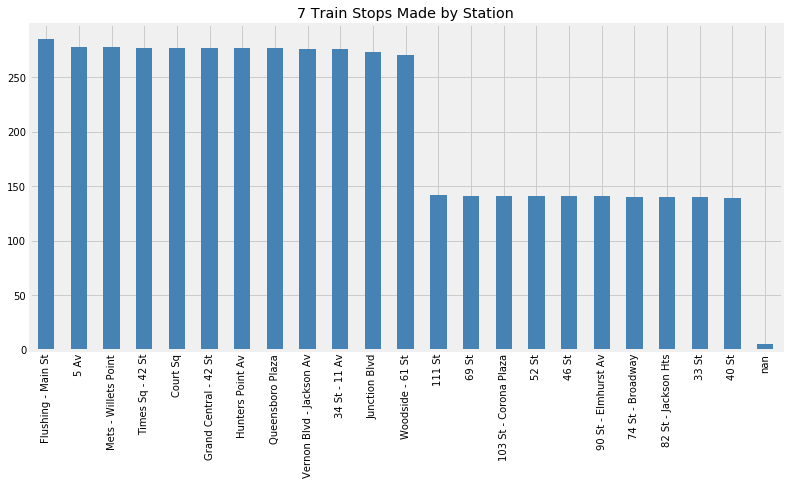

In [37]:
trains.stop_name.value_counts(dropna=False).sort_values(ascending=False).plot.bar(
    color='steelblue', figsize=(12, 6),
    title='7 Train Stops Made by Station'
)

The 7 train is split into a local service which makes all stops and an express service which makes an expedited set of stops during rush hours only. The rush hour trains skipped the second of stops in this dataset: 33 Street, 46 Street, and so on. Looking at this chart, we can see that there were around 275 or so total 7 train trips that day. About half of those trips were local and half were express.

The `nan` values here are for stop IDs with no corresponding stop name in the GTFS record. This seems like a data error on the MTA's part; maybe these stops are for the train yard?

In [38]:
trains.groupby('unique_trip_id').route_id.head(1).value_counts()

7     332
7X      3
Name: route_id, dtype: int64

The `route_id` identifies the headsign a train is running under. Just three of the trains that ran that day were identified as `7X`, e.g. "7 express" trains. Most of the trains that ran the express service were identified as regular `7` trains in the data stream. So the only reliable way to know whether a 7 train is express or local is to look at its actual stop sequence.

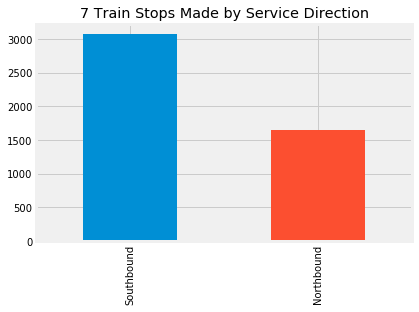

In [39]:
trains.stop_id.map(lambda stop_id: 'Northbound' if 'N' in stop_id else 'Southbound').value_counts().plot.bar(
    title='7 Train Stops Made by Service Direction'
)

One interesting fact about the 7 train is that the number of northbound and southbound stops are *not* equal. The 7 train made over 3500 southbound stops that day, but only a touch over 2100 northbound ones.

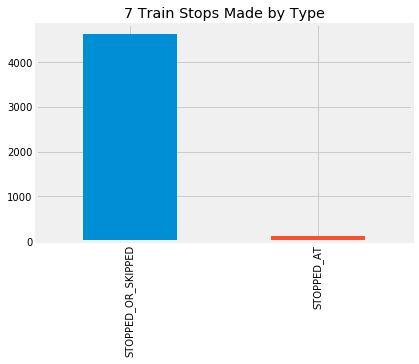

In [40]:
trains.action.value_counts().plot.bar(title='7 Train Stops Made by Type')

As I had explained previously, the 7 train very rarely reports being at a station (`STOPPED_AT`), tending to report being on its way to that station, and then its way to the *next* station, instead (`STOPPED_OR_SKIPPED`).

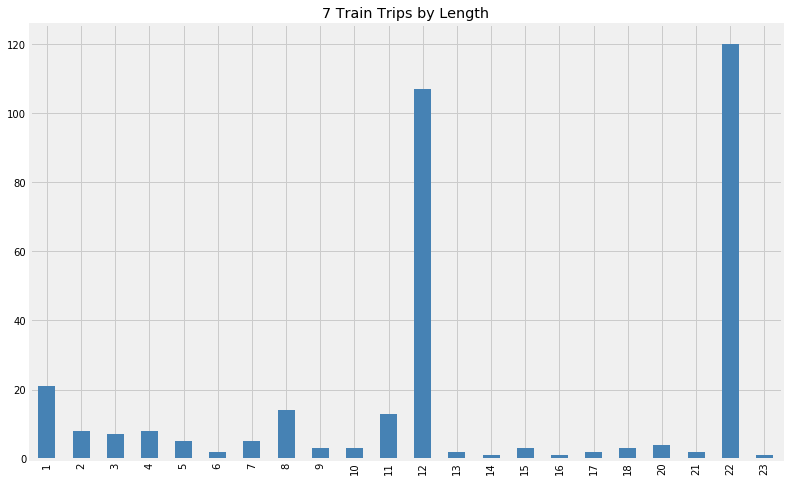

In [41]:
trains.assign(n=0).groupby('unique_trip_id').agg(len).n.value_counts().sort_index().plot.bar(
    figsize=(12, 8), color='steelblue', title='7 Train Trips by Length'
)

If we look at the trips that were made based on their length, we can clearly see two peaks: one at 22, the number of stops typically made by local trains, and one at 12, the number of stops typically made by express trains.

Trains may make fewer or more stops per trip due to delays or incidents forcing trains to skip certain stops. This is likely the reason for the relatively large number of train that made 11 stops that day, for example, instead of 12.

However, because of how the MTA codes its systems, it's also possible for a train to seem to make fewer or more stops than it actually made due to **trip fragmentation**. This occurs when the MTA scrubs a schedule whose estimates have become inaccurate, usually due to delays, and inserts a new schedule with a new `trip_id` instead. Since it's not always possible to detect when this has happened, and the result is that a single train trip will get cut into two (or more!) pieces.

For example, consider the 20 or so case where a train seemed to make only 1 stop. This occurs when the MTA scrubs a schedule for a train that is currently in a station, assigns a new one, and then scrubs *that* schedule as well.

The `gt.ops.cut_cancellations` method we ran earlier removes stops that are actually artifacts of trip fragmentation. This is discussed in more detail in the section of the documentation on [Additional methods](https://residentmario.github.io/gtfs-tripify/additional_methods.html). But due to the way the data is formatted, it's often not possible to patch over train trips that are split into several different segments.

The amount of trip fragmentation varies from line to line, and is especially bad on days in which trains suffer heavy dealys. Since every 7 train begins and ends its service at either Flushing – Main Street or 34 St - 11 Avenue, depending on the heading (northbound or southbound) of the train, checking fragmentation is relatively easy:

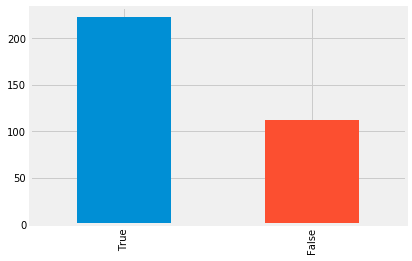

In [57]:
def check_if_trip_is_complete(df):
    first_and_last = df.iloc[[0, -1]].stop_name
    if pd.isnull(first_and_last).any():
        return False
    else:
        return list(sorted(df.iloc[[0, -1]].stop_name)) == ['34 St - 11 Av', 'Flushing - Main St']

(trains.groupby('unique_trip_id')
 .apply(check_if_trip_is_complete)
 .value_counts().plot.bar())

Two thirds of the train trips included in this dataset are complete&mdash;e.g. they record all of the stops the train took, from the first stop all the way to the last. The remaining one-third of stops are incomplete; they record trips that have been split into two or more segments.

A schedule getting scrubbed almost always means that the train is experiencing significant delays. By looking at what station the train was sitting in or going to right before the schedule was scrubbed, we can see which stops trains tended to get delayed at.

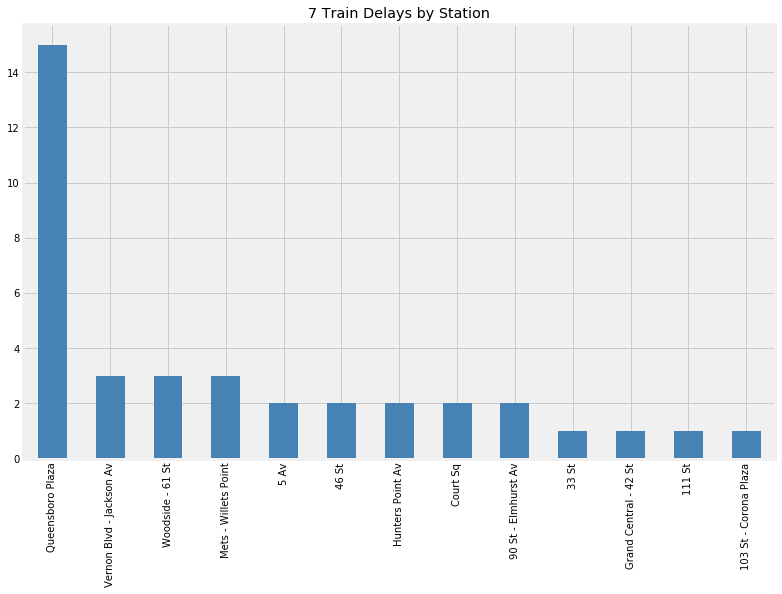

In [68]:
def get_problematic_station(df):
    first_and_last = df.iloc[[0, -1]].stop_name
    if pd.isnull(first_and_last).any():
        return None
    elif not list(sorted(df.iloc[[0, -1]].stop_name)) == ['34 St - 11 Av', 'Flushing - Main St']:
        last_station = df.iloc[-1].stop_name
        if last_station == 'Flushing - Main St' or last_station == '34 St - 11 Av':
            return None
        else:
            return df.iloc[-1].stop_name

(trains.groupby('unique_trip_id')
 .apply(get_problematic_station)
 .value_counts().plot.bar(color='steelblue', figsize=(12, 8), title='7 Train Delays by Station'))

It looks like many of the delays that day occurred near Queensbororo Plaza.

In [331]:
stop_sequence = [
 'Flushing - Main St',
 'Mets - Willets Point',
 '111 St',
 '103 St - Corona Plaza',
 'Junction Blvd',
 '90 St - Elmhurst Av',
 '82 St - Jackson Hts',
 '74 St - Broadway',
 '69 St',
 'Woodside - 61 St',
 '52 St',
 '46 St',
 '40 St',
 '33 St',
 'Queensboro Plaza',
 'Court Sq',
 'Hunters Point Av',
 'Vernon Blvd - Jackson Av',
 'Grand Central - 42 St',
 '5 Av',
 'Times Sq - 42 St',
 '34 St - 11 Av'
]

def plot_trains(trains, title):
    estimated_times = []
    for min_timestamp, max_timestamp in zip(trains.minimum_time, trains.maximum_time):
        estimated_times.append(
            min_timestamp + (max_timestamp - min_timestamp) / 2
        )

    timetable = pd.pivot_table(
        trains.assign(estimated_arrival_time=estimated_times),
        index='unique_trip_id',
        columns='stop_name',
        values='minimum_time'
    ).T.reindex(stop_sequence)

    ax = timetable.rename_axis(None).plot.line(legend=False, color='black', linewidth=1, figsize=(16, 24))
    ax.axvline(0, color='black', linewidth=1)
    ax.axvline(21, color='black', linewidth=1)
    plt.xticks([0 , 21], [stop_sequence[0], stop_sequence[1]], fontsize=16)
    plt.yticks([], [])
    plt.title(title, fontsize=16)
    sns.despine(left=True, bottom=True)

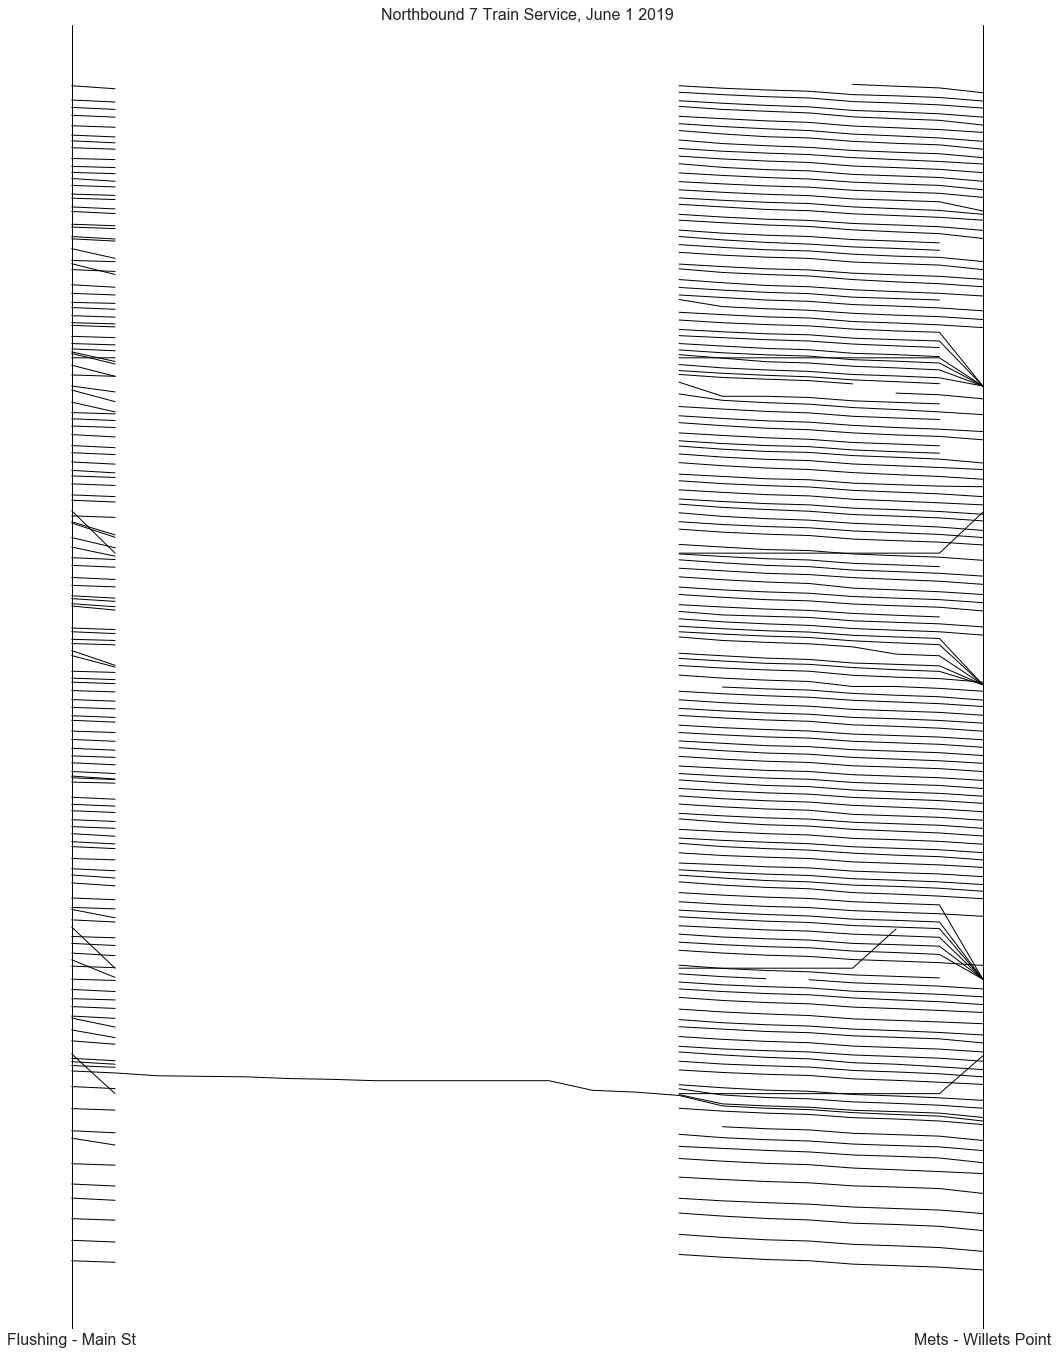

In [332]:
northbound_trains = trains[trains.stop_id.map(lambda v: 'N' in v)]
plot_trains(northbound_trains, 'Northbound 7 Train Service, June 1 2019')

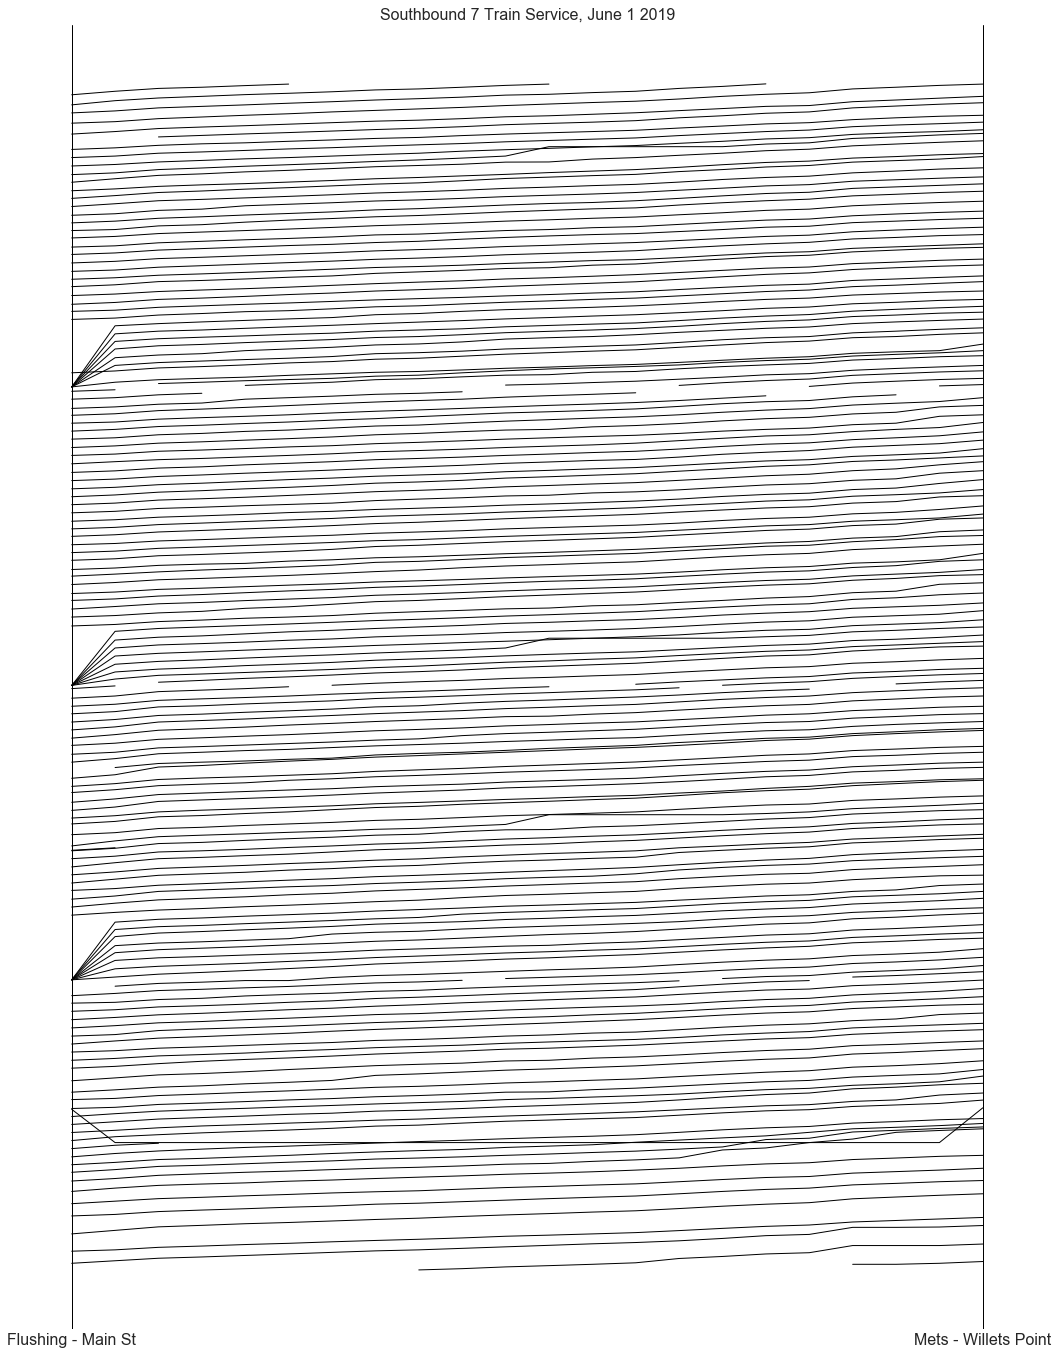

In [333]:
southbound_trains = trains[trains.stop_id.map(lambda v: 'S' in v)]
plot_trains(southbound_trains, 'Southbound 7 Train Service, June 1 2019')